In [7]:
import torch
import torch.nn as nn
from networks import DynamicUNet, LearnableScaleDynamicUNet
from networks import dice_score

device = "cuda" if torch.cuda.is_available() else "cpu"

#network = DynamicUNet(1, 2, [128, 256, 512], [128, 128, 64]).to(device)
network = LearnableScaleDynamicUNet(1, 2, [128, 256, 512], 8, [(128, 4), (128, 2), (64, 1)]).to(device)

In [10]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import cv2 as cv
import os
import numpy as np
import re

class SegmentationDataset(Dataset):
    def __init__(self, ids, patch_folder="./segmentation/patches", mask_folder="./segmentation/masks", scale=1):
        self.ids = ids
        self.mask_folder = mask_folder
        self.patch_folder = patch_folder
        self.scale = scale
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, index):
        patch_path = os.path.join(self.patch_folder, "org_{}.bmp".format(self.ids[index]))
        mask_path = os.path.join(self.mask_folder, "mask_{}.bmp".format(self.ids[index]))

        patch = np.expand_dims(cv.imread(patch_path, cv.IMREAD_GRAYSCALE)/255.0, 0)
        #patch = np.expand_dims(cv.resize(patch, None, fx=self.scale, fy=self.scale), 0)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        mask = cv.resize(mask, None, fx=self.scale, fy=self.scale, interpolation=cv.INTER_NEAREST)

        return torch.tensor(patch, dtype=torch.float), torch.tensor(mask, dtype=torch.long)

ids = [ re.findall("[0-9]+", name)[0] for name in os.listdir("./segmentation/patches") ]

train, test = train_test_split(ids, test_size=40)

In [11]:
learning_rate = 1e-4
batch_size = 10

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction="sum")

plateau_window = 5  # Detect plateau if training doesn't progress after num epochs
# plateau_lambda = 0.01 # Detect plateau if difference between current and best is less than lambda

scales = [1/8, 1/4, 1/2, 1]

losses = [ [] for _ in scales ]
dice_scores = [ [] for _ in scales ]

for i, scale in enumerate(scales):
    breakthrough = 999
    since = 0
    side = 128 * scale

    # train_dataset = SegmentationDataset(train, scale=scale)
    # test_dataset = SegmentationDataset(test, scale=scale)
    train_dataset = SegmentationDataset(train, scale=scale)
    test_dataset = SegmentationDataset(test, scale=scale)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    while since != plateau_window:
        # Training
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            x_hat = network(X)
            loss = train_loss_fn(x_hat, y)
            loss.backward()
            optimizer.step()

        # Testing
        with torch.no_grad():
            loss = 0
            dice_score_ = 0
            for X, y in test_loader:
                X, y = X.to(device,), y.to(device)
                x_hat = network(X)
                loss += test_loss_fn(x_hat, y).item()
                dice_score_ += dice_score(x_hat, y, reduction="sum")
            loss = loss / (len(test_dataset) * side * side ) 
            dice_score_ = dice_score_.detach().cpu().numpy() / len(test_dataset)
            dice_scores[i].append(dice_score_)
            since += 1
            if loss < breakthrough:
                breakthrough = loss
                since=0
            print("Loss:", loss, "Dice score:", dice_score_)
            losses[i].append(loss)
    print("Epoch ended")
    network.use_higher_layer()

Loss: 0.2577120900154114 Dice score: 0.8570674896240235
Loss: 0.19458557069301605 Dice score: 0.9034748077392578
Loss: 0.1615250289440155 Dice score: 0.9176140785217285
Loss: 0.14444008469581604 Dice score: 0.9257383346557617
Loss: 0.1324086755514145 Dice score: 0.9352184295654297
Loss: 0.1259526640176773 Dice score: 0.9380199432373046
Loss: 0.1221404641866684 Dice score: 0.9362394332885742
Loss: 0.12089219391345978 Dice score: 0.9356554031372071
Loss: 0.11839567124843597 Dice score: 0.9346089363098145
Loss: 0.11202630549669265 Dice score: 0.939411735534668
Loss: 0.11148975342512131 Dice score: 0.9389880180358887
Loss: 0.11021814793348313 Dice score: 0.9379261016845704
Loss: 0.10799432843923569 Dice score: 0.9376068115234375
Loss: 0.10757540613412857 Dice score: 0.936956787109375
Loss: 0.10561098754405976 Dice score: 0.9398446083068848
Loss: 0.10524015128612518 Dice score: 0.9371078491210938
Loss: 0.1039875790476799 Dice score: 0.9390108108520507
Loss: 0.10357439517974854 Dice score: 0

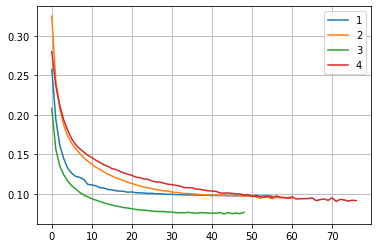

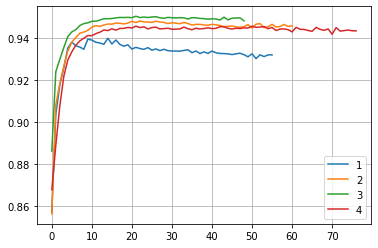

In [12]:
import matplotlib.pyplot as plt

plt.figure()
for loss in losses:
    plt.plot(loss)
plt.legend([1,2,3,4])
plt.grid()
plt.show()

plt.figure()
for dice in dice_scores:
    plt.plot(dice)
plt.legend([1,2,3,4])
plt.grid()
plt.show()

In [5]:
dice_scores[2]

[0.8710060119628906,
 0.9151926040649414,
 0.9269527435302735,
 0.9339389801025391,
 0.9363704681396484,
 0.9404860496520996,
 0.9438300132751465,
 0.9452865600585938,
 0.9493058204650879,
 0.9495021820068359,
 0.9509185791015625,
 0.9509578704833984,
 0.9518979072570801,
 0.9524374008178711,
 0.9526115417480469,
 0.9523500442504883,
 0.953359317779541,
 0.9529186248779297,
 0.9527953147888184,
 0.9536738395690918,
 0.9528157234191894,
 0.9524642944335937,
 0.9525443077087402,
 0.9527738571166993,
 0.9529973983764648,
 0.9529194831848145,
 0.9523104667663574,
 0.9531717300415039,
 0.953521728515625,
 0.9539130210876465,
 0.9562312126159668,
 0.9552539825439453,
 0.9552264213562012,
 0.9549253463745118,
 0.9544878959655761,
 0.9543079376220703,
 0.9550607681274415,
 0.9541223526000977,
 0.9538721084594727,
 0.9545344352722168,
 0.9544055938720704,
 0.9537544250488281,
 0.9550196647644043,
 0.9553730010986328,
 0.9534436225891113,
 0.954200553894043,
 0.9551422119140625,
 0.9544222831726

In [6]:
from torchviz import make_dot

val = network(torch.randn((1, 1, 128, 128)).cuda()).cpu()

make_dot(val.sum(), params=dict(list(network.named_parameters()))).render("torchviz3", format="png")

'torchviz3.png'

In [7]:

# temp_ = network.additional_mapper_classifiers[-2]["mapper"](torch.randn((5, 1, 128, 128)))

# add_down_ = network.additional_downscale[-2](temp_)
# downscaled_ = network.downscale(add_down_)

# #-----------------------------------#

# # temp = network.additional_mapper_classifiers[-1]["mapper"](torch.randn((5, 1, 64, 64)))

# add_down = network.additional_downscale[-1](downscaled_)
# downscaled = network.downscale(add_down)

# y_hat = network.base_unet(downscaled)

# upscaled = network.additional_upscale[-1]["upsample_conv"](y_hat)

# sth = torch.cat([upscaled, add_down], dim=1)

# res = network.additional_upscale[-1]["conv_cell"](sth)

# # res = network.additional_mapper_classifiers[-1]["classifier"](res)

# #-----------------------------------#

# upscaled = network.additional_upscale[-2]["upsample_conv"](res)

# sth = torch.cat([upscaled, add_down_], dim=1)

# res = network.additional_upscale[-2]["conv_cell"](sth)

# res = network.additional_mapper_classifiers[-2]["classifier"](res)


In [8]:
import torch
from networks import dice_score

tab1 = torch.randn((10, 2, 64, 64))
tab2 = torch.randn((10, 64, 64)) > 0

dice_score(tab1, tab2)

tensor(0.5017)

In [9]:
len(network.additional_mapper_classifiers)

3

In [10]:
while(network.use_higher_layer() != True):
    pass